<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/Pose%20Estimation%20with%20keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the next code block. There will be two separate authentications needed. The first will download all extra files from the CIS580 shared drive files. The second connects your google drive to save files to 'cis580-2019-hw6'

In [1]:
# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
        '1PIhom4rR_a_vm-zCt_1rYKbz8sd43Gel': "data/images.npz",
        '1IOxsTUF-MgmDRp3-0jPMJ-qo8yLZFCez': "data/train_data.npz",
        '1ZPRZoiuQVwWm88dWB4kWTBTtSQKBaDxs': "data/valid_data.npz",
        '1rJgn9NHdnwToyIERWbS8g_gZu19wAkkd': "data/kpt.npy",
        '1noGbThisv1HOi87dG66AfgQzpIv0o1y6': "data/misc_data.npz",
        '1Jp94eNQyXlTBYhqFFksbwRRl9VOGLAYT': "utils/__init__.py",
        '1UCCx78ZFL-BxsIScl0YkaLSRjw6Umliu': "utils/pose_utils.py",
        '1lV3oSGB2ygBj0vF2zaj_FKVaExz4-loi': "utils/plotting.py",
        '1td00aFXojVptGMz1XRTuVWSdpAHYi4lt': "utils/train_options.py",
        '18NNIqvS5-GB9xGWJX0wjHeC_RaaoKnWz': "hourglass.py",
        '1mJS9HFhDoUR1XGxRNQm2e-j4WZQn7Zhl': "dataset.py",
           }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)

# mount the user's google drive into the system
from google.colab import drive
drive.mount('/content/gdrive')
# create folder to write data to
os.makedirs('/content/gdrive/My Drive/cis580-2019-hw6', exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The next code block handles the external library imports.

In [0]:
from __future__ import division
from __future__ import print_function

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

from hourglass import hg

from dataset import Dataset
from dataset import RandomFlipLR, RandomRescaleBB, RandomRotation,\
                    CropAndPad, LocsToHeatmaps,\
                    ToTensor, Normalize, Denormalize
from utils import TrainOptions, PoseUtils

from tqdm import tqdm
from PIL import Image
import os
from time import time
import numpy as np


Step 1) The Trainer class contains two locations where you must implement the training step and the test step as specified in the accompanying PDF

In [0]:
class Trainer(object):

    def __init__(self, options):
        self.options = options
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        train_transform_list = []
        train_transform_list.append(RandomRescaleBB(0.8, 1.2))
        train_transform_list.append(RandomFlipLR())
        train_transform_list.append(RandomRotation(degrees=options.degrees))
        train_transform_list.append(CropAndPad(out_size=(options.crop_size, options.crop_size)))
        train_transform_list.append(LocsToHeatmaps(out_size=(options.heatmap_size, options.heatmap_size)))
        train_transform_list.append(ToTensor())
        train_transform_list.append(Normalize())
        test_transform_list = [CropAndPad(out_size=(options.crop_size, options.crop_size))]
        test_transform_list.append(LocsToHeatmaps(out_size=(options.heatmap_size, options.heatmap_size)))
        test_transform_list.append(ToTensor())
        test_transform_list.append(Normalize())
        self.train_ds = Dataset(is_train=True, transform=transforms.Compose(train_transform_list))
        self.test_ds = Dataset(is_train=False, transform=transforms.Compose(test_transform_list))

        self.model = hg(num_stacks=options.num_stacks, num_blocks=options.num_blocks, num_classes=options.num_classes).to(self.device)
        # define loss function and optimizer
        self.heatmap_loss = torch.nn.MSELoss().to(self.device) # for Global loss
        self.optimizer = torch.optim.RMSprop(self.model.parameters(),
                                             lr = options.lr)


        self.pose_utils = PoseUtils(detection_thresh=options.detection_thresh, dist_thresh=options.dist_thresh)

        self.train_data_loader = DataLoader(self.train_ds, batch_size=options.batch_size,
                                            num_workers=options.num_workers,
                                            pin_memory=True,
                                            shuffle=True)
        self.test_data_loader = DataLoader(self.test_ds, batch_size=options.test_batch_size,
                                           num_workers=options.num_workers,
                                           pin_memory=True,
                                           shuffle=True)

        self.summary_iters = []
        self.losses = []
        self.pcks = []

    def train(self):
        self.total_step_count = 0
        start_time = time()
        for epoch in range(1,self.options.num_epochs+1):
            elapsed_time = time() - start_time
            seconds_per_epoch = elapsed_time / epoch
            remaining_time = (self.options.num_epochs - epoch) * seconds_per_epoch

            print("Epoch %d/%d - Elapsed Time %f - Remaining Time %f" %
                    (epoch, self.options.num_epochs,
                        elapsed_time, remaining_time))
            
            running_loss = 0.0
            
            for step, batch in enumerate(self.train_data_loader):
                self.model.train()
                batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                """
                ADD YOUR CODE FOR THE TRAINING STEP HERE
                You have to name the output of your neural network pred_heatmap_list
                This list contains the output heatmaps for each stack of the Stacked Hourglass model
                Since we are using only 1 stack in this homework, pred_heatmap_list will contain only 1 tensor
                """
                inputs = batch['image']
                labels = batch['keypoint_heatmaps']
                pred_heatmap_list = self.model(inputs)
#                 print(pred_heatmap_list)
                loss = self.heatmap_loss(pred_heatmap_list[-1], labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                
                self.total_step_count += 1
                if self.total_step_count % self.options.summary_steps == 0:
                    self.save_summaries(batch, pred_heatmap_list[-1].detach(), loss.detach(), mode='train')
                if self.total_step_count % self.options.test_steps == 0:
                    self.model.eval()
                    batch = next(iter(self.test_data_loader))
                    batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                    """
                    ADD YOUR CODE FOR THE TEST STEP HERE
                    What you have to do is to perform a forward pass and record the loss and the output
                    """
                    test_inputs = batch['image']
                    test_labels = batch['keypoint_heatmaps']                
                    with torch.no_grad():
                      pred_heatmap_list = self.model(test_inputs)
                      loss = self.heatmap_loss(pred_heatmap_list[-1], test_labels)
                    
                    self.save_summaries(batch, pred_heatmap_list[-1], loss, mode='test')

        checkpoint = {'model': self.model.state_dict()}
        torch.save(checkpoint, '/content/gdrive/My Drive/cis580-2019-hw6/model_checkpoint.pt')

    def save_summaries(self, batch, pred_heatmaps, loss, mode='train'):
        gt_heatmaps = batch['keypoint_heatmaps'].to(self.device)
        pck = self.pose_utils.pck(gt_heatmaps, pred_heatmaps)

        batch = Denormalize()(batch)
        images = batch['image']

        gt_image_keypoints, pred_image_keypoints = self.pose_utils.draw_keypoints_with_labels(images, gt_heatmaps, pred_heatmaps)

        gt_image_keypoints_grid = make_grid(gt_image_keypoints, pad_value=1, nrow=3)
        pred_image_keypoints_grid = make_grid(pred_image_keypoints, pad_value=1, nrow=3)

        pred_heatmaps_grid = make_grid(pred_heatmaps[0,:,:,:].unsqueeze(0).transpose(0,1), pad_value=1, nrow=5)
        pred_heatmaps_grid[pred_heatmaps_grid > 1] = 1
        pred_heatmaps_grid[pred_heatmaps_grid < 0] = 0

        self.losses.append(loss)
        self.pcks.append(pck)
        self.summary_iters.append(self.total_step_count)

        folder = '/content/gdrive/My Drive/cis580-2019-hw6/logs/%d' % self.total_step_count
        os.makedirs(folder, exist_ok=True)

        gt_ikg = Image.fromarray((gt_image_keypoints_grid.cpu().detach().numpy().transpose(1,2,0) * 255.).astype(np.uint8))
        pred_ikg = Image.fromarray((pred_image_keypoints_grid.cpu().detach().numpy().transpose(1,2,0) * 255.).astype(np.uint8))
        pred_hg = Image.fromarray((pred_heatmaps_grid.cpu().detach().numpy().transpose(1,2,0) * 255.).astype(np.uint8))

        gt_ikg.save(os.path.join(folder, mode + '_gt_image_keypoints.jpg'))
        pred_ikg.save(os.path.join(folder, mode + '_pred_image_keypoints.jpg'))
        pred_hg.save(os.path.join(folder, mode + '_pred_heatmaps.jpg'))

The next block will start the training process. Be sure to run the above block first every time you want to test changes to the code.

In [0]:
options = TrainOptions().parse_args(["--name=gascan",
                                     "--summary_steps=200",
                                     "--num_epochs=400",
                                     "--test_steps=1000"])
trainer = Trainer(options)
trainer.train()

Epoch 1/400 - Elapsed Time 0.000006 - Remaining Time 0.002568
Epoch 2/400 - Elapsed Time 5.259043 - Remaining Time 1046.549553
Epoch 3/400 - Elapsed Time 10.541828 - Remaining Time 1395.035196
Epoch 4/400 - Elapsed Time 15.908446 - Remaining Time 1574.936138
Epoch 5/400 - Elapsed Time 21.234416 - Remaining Time 1677.518883
Epoch 6/400 - Elapsed Time 26.599221 - Remaining Time 1746.682147
Epoch 7/400 - Elapsed Time 31.865571 - Remaining Time 1789.024188
Epoch 8/400 - Elapsed Time 37.089296 - Remaining Time 1817.375497
Epoch 9/400 - Elapsed Time 42.463186 - Remaining Time 1844.789506
Epoch 10/400 - Elapsed Time 47.733543 - Remaining Time 1861.608165
Epoch 11/400 - Elapsed Time 53.218842 - Remaining Time 1882.011760
Epoch 12/400 - Elapsed Time 61.167623 - Remaining Time 1977.753153
Epoch 13/400 - Elapsed Time 66.774595 - Remaining Time 1987.828329
Epoch 14/400 - Elapsed Time 72.196412 - Remaining Time 1990.558212
Epoch 15/400 - Elapsed Time 77.728433 - Remaining Time 1995.029790
Epoch 16/

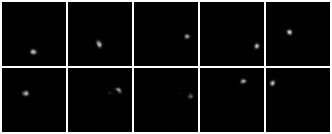

In [12]:
from IPython.display import Image as disp_Image

disp_Image(filename='/content/gdrive/My Drive/cis580-2019-hw6/logs/7000/test_pred_heatmaps.jpg') 


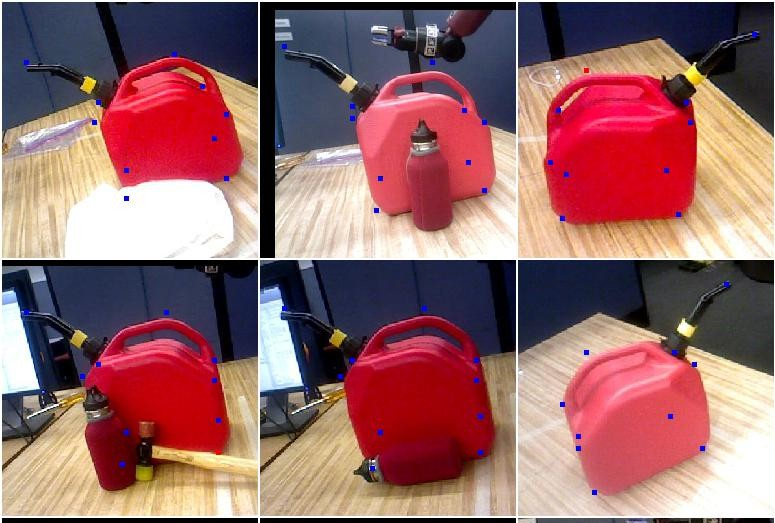

In [13]:
disp_Image(filename='/content/gdrive/My Drive/cis580-2019-hw6/logs/7000/test_pred_image_keypoints.jpg') 


The next block will run prediction on the test set and save the output detections

In [0]:
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from hourglass import hg

from dataset import Dataset
from dataset import CropAndPad, LocsToHeatmaps, ToTensor, Normalize
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = hg(num_stacks=1, num_blocks=1, num_classes=10).to(device)
checkpoint = torch.load('/content/gdrive/My Drive/cis580-2019-hw6/model_checkpoint.pt')
model.load_state_dict(checkpoint['model'])
transform_list = [CropAndPad(out_size=(256, 256))]
transform_list.append(LocsToHeatmaps(out_size=(64,64)))
transform_list.append(ToTensor())
transform_list.append(Normalize())
test_ds = Dataset(is_train=False, transform=transforms.Compose(transform_list))
data_loader = DataLoader(test_ds, batch_size=1, pin_memory=True, shuffle=False)
predicted_heatmaps = np.zeros((len(test_ds), 10, 64, 64))
for i, batch in enumerate(tqdm(data_loader)):
    model.eval()
    images = batch['image'].to(device)
    with torch.no_grad():
        pred_heatmap_list = model(images)
    pred_heatmaps = pred_heatmap_list[-1]
    predicted_heatmaps[i,:,:,:] = pred_heatmaps[0,:,:,:].cpu().numpy()
np.save('/content/gdrive/My Drive/cis580-2019-hw6/detections.npy', predicted_heatmaps)

100%|██████████| 27/27 [00:00<00:00, 34.42it/s]


Import the external and given functions for step 2

In [0]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
from os.path import join
from utils import plot_mesh
import math



"""
Convert axis-angle representation to a 3x3 rotation matrix
"""
class Rodrigues(torch.autograd.Function):
    @staticmethod
    def forward(self, inp):
        pose = inp.detach().cpu().numpy() #bringing back to cpu so that we can use opencv function and numpy
        rotm, part_jacob = cv2.Rodrigues(pose)
        self.jacob = torch.Tensor(np.transpose(part_jacob)).contiguous()
        rotation_matrix = torch.Tensor(rotm.ravel())
        return rotation_matrix.view(3,3)

    @staticmethod
    def backward(self, grad_output):
        grad_output = grad_output.view(1,-1)
        grad_input = torch.mm(grad_output, self.jacob)
        grad_input = grad_input.view(-1)
        return grad_input
"""
This is the function you should call to convert fom axis-angle to a rotation matrix
Example usage:
    aa = torch.zeros(3)
    R = rodrigues(aa)
"""
rodrigues = Rodrigues.apply

Step 2) Implement pose_optimization and heatmaps_to_locs as specified by the accompanying PDF

In [0]:
"""
YOU NEED TO IMPLEMENT THIS
Input: image, mesh vertices, mesh faces, detected 2d keypoints, keypoint confidences, 3D keypoint coordinates in the canonical position, intrinsic camera matrix
Output: R, t
"""
def pose_optimization(img, vertices, faces, keypoints_2d, conf, keypoints_3d, K):
  
    
    # Send variables to GPU
    device = keypoints_2d.device
    keypoints_3d = keypoints_3d.to(device)
    K = K.to(device)
    r = torch.rand(3, requires_grad=True, device=device) # rotation in axis-angle representation
    t = torch.rand(3 ,requires_grad=True, device=device)
    d = conf.sqrt()[:, None]
    # 2D keypoints in normalized coordinates
    norm_keypoints_2d = torch.matmul(K.inverse(), torch.cat((keypoints_2d, torch.ones(keypoints_2d.shape[0],1, device=device)), dim=-1).t()).t()[:,:-1]
    # set up optimizer
    optimizer = torch.optim.Adam([r,t], lr=1e-2)
    # converge check
    converged = False
    rel_tol = 1e-5
    loss_old = 100
    while not converged:
      # convert axis-angle to rotation matrix
      R = rodrigues(r)
      # 1) Compute projected keypoints based on current estimate of R and t
      # 2) Compute error (based on distance between projected keypoints and detected keypoints)
      # 3) Update based on error
      # 4) Check for convergence
      proj_keypoints = torch.add(torch.matmul(R,keypoints_3d.transpose(0,1)),t.reshape([3,1]))
      proj_keypoints = torch.div(proj_keypoints,proj_keypoints[2,:])
      
      
      residual = torch.norm(norm_keypoints_2d.transpose(0,1) - proj_keypoints[0:2,:] , dim=0)
      
      
      loss = torch.matmul(residual,d)

#       print(loss)
      
      if(torch.abs(loss - loss_old) <= rel_tol):
        converged = True      
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_old = loss
      # IMPLEMENT THE ABOVE

    R = rodrigues(r)
    proj_keypoints = proj_keypoints.transpose(0,1)[:,0:2] 
#     print(proj_keypoints)
    plt.figure()
    plot_mesh(img, vertices, faces, R.detach().cpu().numpy(), t.detach().cpu().numpy()[:,None], K.detach().cpu().numpy())
    pk = torch.matmul(K, torch.cat((proj_keypoints, torch.ones(proj_keypoints.shape[0], 1, device=device)), dim=-1).t()).t()
#     pk = torch.matmul(K, proj_keypoints).t() 
    pk = pk.detach().cpu().numpy()
    plt.scatter(pk[:,0], pk[:,1], color='r')
    plt.show()
    return rodrigues(r)[0].detach(), t.detach()

"""
YOU NEED TO IMPLEMENT THIS
Convert heatmaps to 2D locations
Input: Nx10x64x64 keypoint heatmaps
Output: Nx10x3 keypoint locations and detection confidence (magnitude of the highest activation)
"""
def heatmaps_to_locs(heatmaps):
  
    keypoint_locations = torch.zeros((heatmaps.size(0),heatmaps.size(1),3), dtype=torch.float32)
#     print(keypoint_locations.size())
    
    for i,tenheatmaps in enumerate(heatmaps):
      for j,oneheatmap in enumerate(tenheatmaps):
        keypoint_locations[i,j,2] = oneheatmap.max()
        keypoint_locations[i,j,1] = torch.tensor(math.floor(oneheatmap.argmax()/oneheatmap.size(1)))
        keypoint_locations[i,j,0] = oneheatmap.argmax()%oneheatmap.size(1)
    
#     print(keypoint_locations)    
    return keypoint_locations

The next block will start the pose optimization process. Be sure to run the above block first every time you want to test changes to the code.

In [0]:
data = np.load('data/misc_data.npz')
K = torch.from_numpy(data['K']).float()
S = torch.from_numpy(np.load('data/kpt.npy'))
vertices = data['vertices']
faces = data['faces']

dataset = np.load('data/valid_data.npz')
imgnames = dataset['imgname']
scales = torch.from_numpy(dataset['scale']).float()[:,None]
centers = torch.from_numpy(dataset['center']).float()
# detections.npy contains the detections saved after training your model and running predict.py
heatmaps = torch.from_numpy(np.load('/content/gdrive/My Drive/cis580-2019-hw6/detections.npy'))

keypoint_locs = heatmaps_to_locs(heatmaps)

# Compute detected 2D keypoint locations in the original image
ul_corner = centers - scales * 100
keypoint_locs[:,:,:-1] *= scales[:,:,None]*200 / 64
keypoint_locs[:,:,:-1] += ul_corner[:,None,:]

images = np.load('data/images.npz')

os.makedirs('/content/gdrive/My Drive/cis580-2019-hw6/pose_optimization', exist_ok=True)
for i in range(len(heatmaps)):
    img_name = imgnames[i].decode('utf-8')
    print("Processing ", img_name)
    img = images[img_name]
    pose_optimization(img, vertices, faces, keypoint_locs[i,:,:-1], keypoint_locs[i,:,-1], S, K)
    plt.show(img)
    plt.savefig('/content/gdrive/My Drive/cis580-2019-hw6/pose_optimization/%s' % img_name, dpi=300)
    plt.close('all')

Processing  train_148.jpg
Processing  train_160.jpg
Processing  train_80.jpg
Processing  train_181.jpg
Processing  train_176.jpg
Processing  train_2.jpg
Processing  train_155.jpg
Processing  train_136.jpg
Processing  train_4.jpg
Processing  train_18.jpg
Processing  train_106.jpg
Processing  train_90.jpg
Processing  train_25.jpg
Processing  train_116.jpg
Processing  train_190.jpg
Processing  train_177.jpg
Processing  train_52.jpg
Processing  train_191.jpg
Processing  train_13.jpg
Processing  train_9.jpg
Processing  train_81.jpg
Processing  train_21.jpg
Processing  train_72.jpg
Processing  train_144.jpg
Processing  train_10.jpg
Processing  train_12.jpg
Processing  train_140.jpg


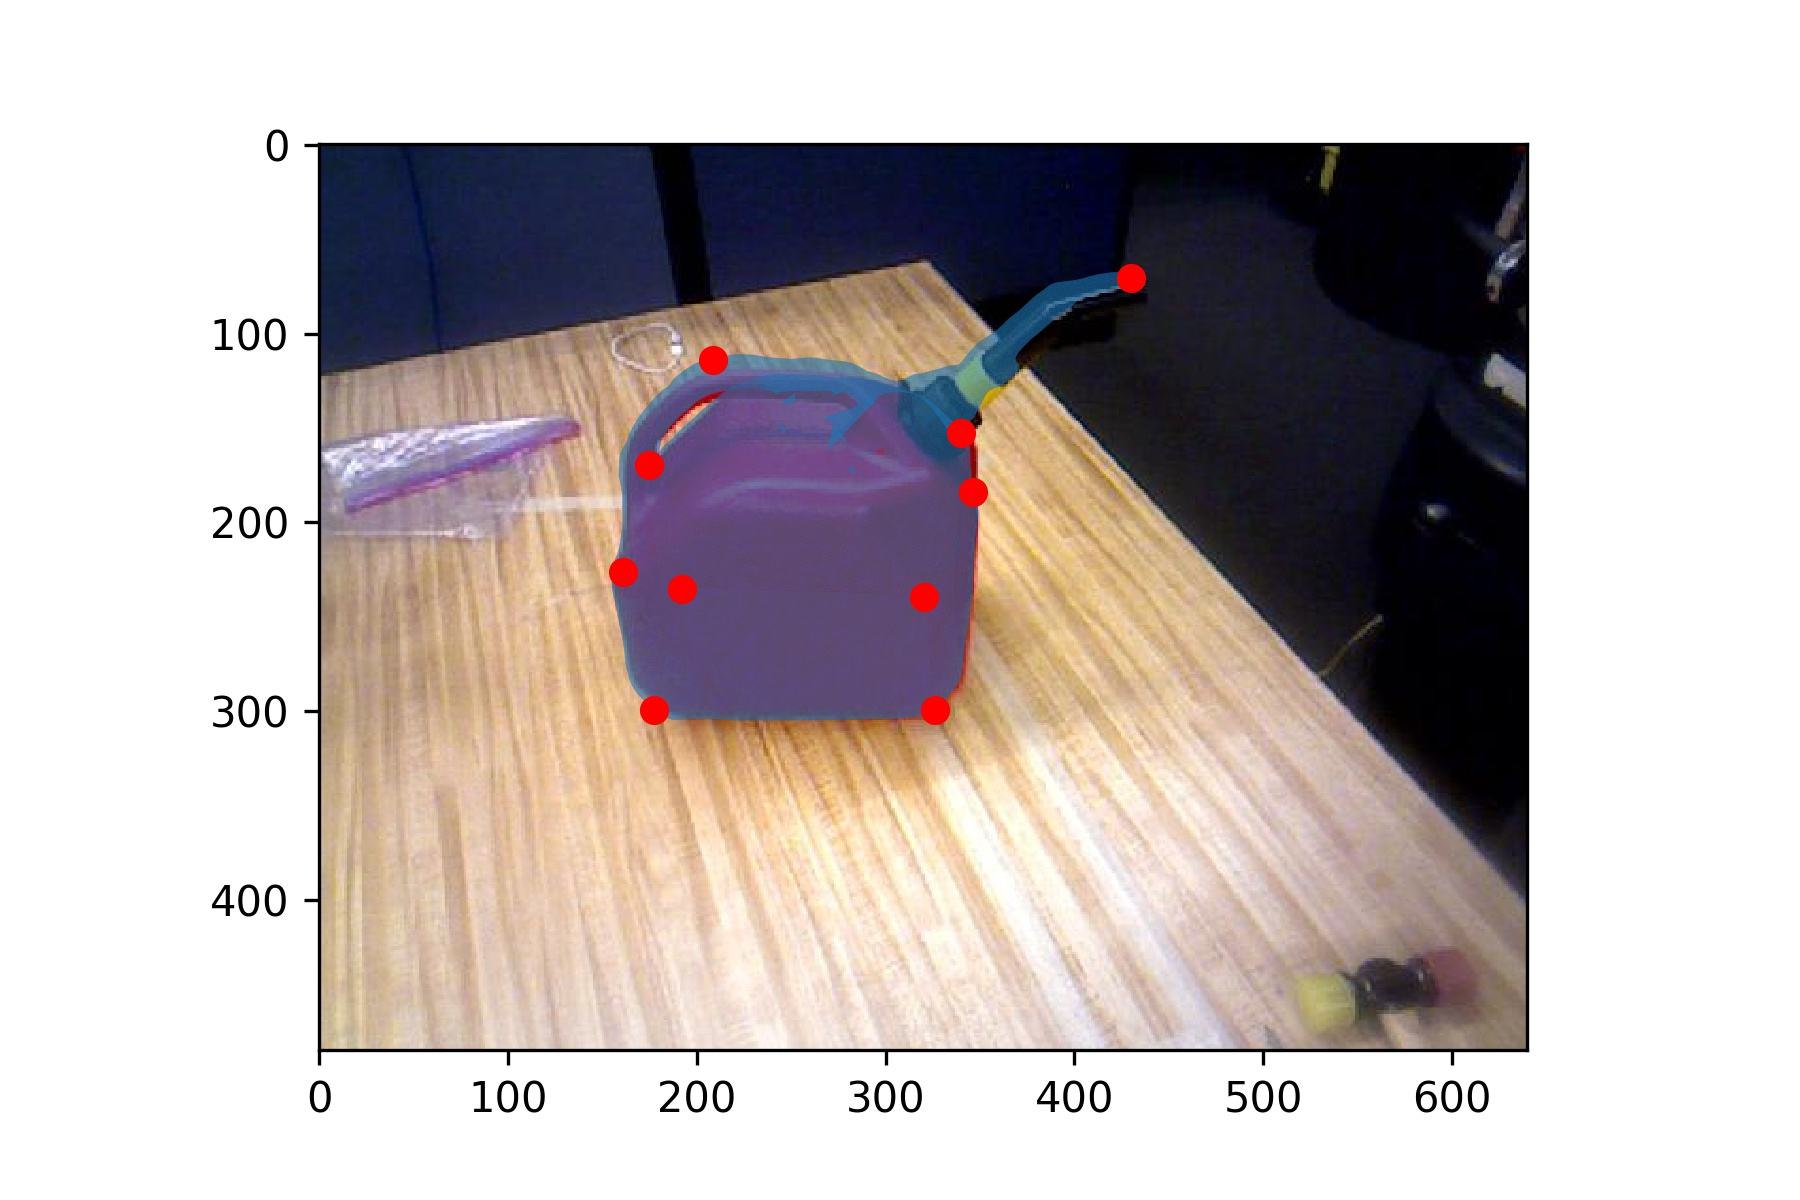

In [6]:
from IPython.display import Image as disp_Image

disp_Image(filename='/content/gdrive/My Drive/cis580-2019-hw6/pose_optimization/train_18.jpg') 